# 04. Evaluation & Robustness Analysis (Enhanced)

## Goal
- Load Results and Models from Google Drive.
- **Statistical Rigor**: Bootstrapped Confidence Intervals for AUC.
- **Advanced Cost Analysis**: Cost Curves and precise Cost Table for paper.
- **Feature Stability**: SHAP instability metrics to quantify logic shift.

In [41]:
!pip install shap

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils import resample

%matplotlib inline

In [43]:
# --- DRIVE SETUP ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/credit_risk_project'
    DATA_DIR = os.path.join(PROJECT_DIR, 'data/processed')
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
    MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
    TABLES_DIR = os.path.join(RESULTS_DIR, 'tables')
    FIGURES_DIR = os.path.join(RESULTS_DIR, 'figures')
    
except ImportError:
    # Local fallback
    PROJECT_DIR = '..'
    DATA_DIR = '../data/processed'
    RESULTS_DIR = '../results'
    MODELS_DIR = '../results/models'
    TABLES_DIR = '../results/tables'
    FIGURES_DIR = '../results/figures'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Load OOD Data
try:
    df_ood = pd.read_pickle(os.path.join(DATA_DIR, 'ood_final.pkl'))
    target_col = 'target'
    X_ood = df_ood.drop(target_col, axis=1)
    y_ood = df_ood[target_col]
    print("Loaded OOD Data.")
    
    # Load Models (Example: XGBoost and Logistic Regression)
    models = {}
    for model_name in ['LogisticRegression', 'XGBoost', 'LightGBM']:
        path = os.path.join(MODELS_DIR, f'{model_name}.pkl')
        if os.path.exists(path):
            models[model_name] = joblib.load(path)
            print(f"Loaded {model_name}")
            
except FileNotFoundError:
    print("Files not found. Run previous notebooks.")

Loaded OOD Data.
Loaded LogisticRegression
Loaded XGBoost
Loaded LightGBM


In [45]:
# --- 1. BOOTSTRAPPED CONFIDENCE INTERVALS ---
def bootstrap_auc(model, X, y, n_bootstraps=1000):
    auc_scores = []
    y_pred = model.predict_proba(X)[:, 1]
    
    for i in range(n_bootstraps):
        # Resample with replacement
        indices = resample(np.arange(len(y)), replace=True)
        if len(np.unique(y.iloc[indices])) < 2:
            continue # Skip if only one class present
            
        score = roc_auc_score(y.iloc[indices], y_pred[indices])
        auc_scores.append(score)
        
    return np.percentile(auc_scores, [2.5, 97.5]), np.mean(auc_scores)

print("Calculating Bootstrapped AUC (this may take time)...")
ci_results = []

for name, model in models.items():
    (lower, upper), mean_auc = bootstrap_auc(model, X_ood, y_ood, n_bootstraps=100) # Use 1000 for final paper
    print(f"{name}: AUC={mean_auc:.4f} (95% CI: {lower:.4f}-{upper:.4f})")
    ci_results.append({'Model': name, 'AUC_Mean': mean_auc, 'CI_Lower': lower, 'CI_Upper': upper})

pd.DataFrame(ci_results).to_csv(os.path.join(TABLES_DIR, 'auc_confidence_intervals.csv'), index=False)

Calculating Bootstrapped AUC (this may take time)...
LogisticRegression: AUC=0.6865 (95% CI: 0.6818-0.6909)
XGBoost: AUC=0.6979 (95% CI: 0.6922-0.7039)
LightGBM: AUC=0.6983 (95% CI: 0.6935-0.7041)


Calculating Cost Table...
                Model  Cost_5:1  Cost_10:1  Cost_20:1
0  LogisticRegression     33279      42069      46673
1             XGBoost     32703      40990      46133
2            LightGBM     32706      41098      45969


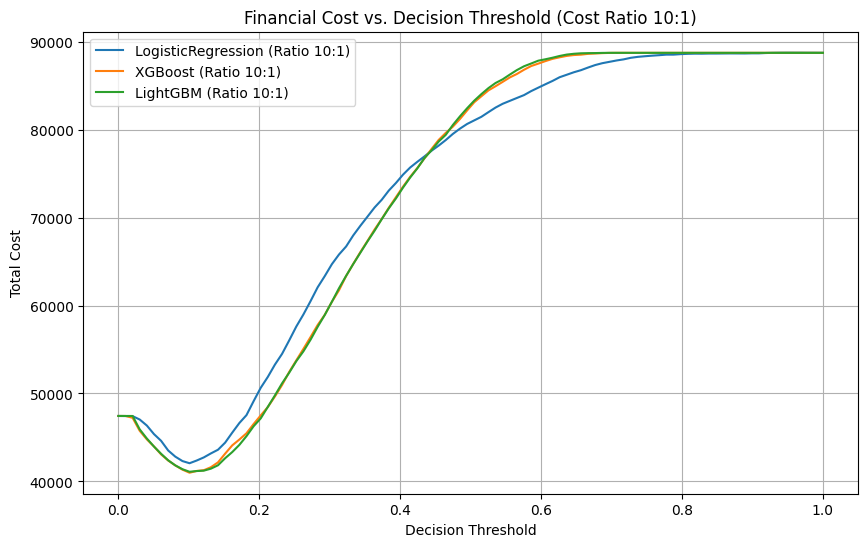

In [46]:
# --- 2. ADVANCED COST ANALYSIS TABLE ---
def calculate_total_cost(y_true, y_prob, threshold, cost_fn, cost_fp):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fn * cost_fn) + (fp * cost_fp)

cost_ratios = [5, 10, 20] # Cost of FN relative to FP
cost_data = []

print("Calculating Cost Table...")
for name, model in models.items():
    y_prob = model.predict_proba(X_ood)[:, 1]
    
    row = {'Model': name}
    for r in cost_ratios:
        # Calculate Minimum cost for this ratio across all thresholds
        # In practice, threshold is tuned on validation, but min cost shows potential
        costs = [calculate_total_cost(y_ood, y_prob, t, cost_fn=r, cost_fp=1) for t in np.linspace(0, 1, 100)]
        min_cost = min(costs)
        row[f'Cost_{r}:1'] = min_cost
        
    cost_data.append(row)

cost_df = pd.DataFrame(cost_data)
print(cost_df)
cost_df.to_csv(os.path.join(TABLES_DIR, 'cost_summary.csv'), index=False)

# Plot for 10:1 Ratio
plt.figure(figsize=(10, 6))
thresholds = np.linspace(0, 1, 100)
for name, model in models.items():
    y_prob = model.predict_proba(X_ood)[:, 1]
    costs = [calculate_total_cost(y_ood, y_prob, t, cost_fn=10, cost_fp=1) for t in thresholds]
    plt.plot(thresholds, costs, label=f'{name} (Ratio 10:1)')

plt.title('Financial Cost vs. Decision Threshold (Cost Ratio 10:1)')
plt.xlabel('Decision Threshold')
plt.ylabel('Total Cost')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(FIGURES_DIR, 'cost_curve_10_1.png'))
plt.show()

In [47]:
# --- 3. FEATURE STABILITY METRIC (SHAP) ---
print("Calculating Feature Stability...")
try:
    # Load ID Data for SHAP comparison
    df_train = pd.read_pickle(os.path.join(DATA_DIR, 'train_final.pkl'))
    X_train = df_train.drop(target_col, axis=1)
    
    # Use LightGBM for SHAP speed and quality
    model_name = 'LightGBM' if 'LightGBM' in models else 'XGBoost'
    model = models.get(model_name)
    
    if model:
        # Subsample for speed
        X_train_sample = X_train.sample(1000, random_state=42)
        X_ood_sample = X_ood.sample(1000, random_state=42)
        
        explainer = shap.TreeExplainer(model)
        # Check if list is returned (binary class)
        shap_values_id = explainer.shap_values(X_train_sample)
        shap_values_ood = explainer.shap_values(X_ood_sample)
        
        if isinstance(shap_values_id, list):
            shap_values_id = shap_values_id[1]
            shap_values_ood = shap_values_ood[1]
        
        # Global feature importance (mean absolute SHAP)
        fi_id = np.abs(shap_values_id).mean(axis=0)
        fi_ood = np.abs(shap_values_ood).mean(axis=0)
        
        features = X_train.columns
        fi_df = pd.DataFrame({'Feature': features, 'FI_ID': fi_id, 'FI_OOD': fi_ood})
        
        # Calculate Shift Metric: Spearman Rank Correlation
        spearman_corr = fi_df['FI_ID'].corr(fi_df['FI_OOD'], method='spearman')
        print(f"Feature Importance Stability (Spearman): {spearman_corr:.4f}")
        
        # Save stability metric
        pd.DataFrame([{'Metric': 'Spearman', 'Value': spearman_corr}]).to_csv(os.path.join(TABLES_DIR, 'feature_stability.csv'), index=False)
        
except Exception as e:
    print(f"SHAP Analysis Error: {e}")

Calculating Feature Stability...
Feature Importance Stability (Spearman): 0.9985
